### Week 7: The KNN classifier

Instructor: Cornelia Paulik <br>
Email: cilin@ischool.berkeley.edu <br>


Citations: <br>
 - Chapter 3, 4, 6: Python Machine Learning 3rd Edition by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2019

#### ``Objectives`` 
 - an intro to building good training datasets (data preprocessing).
 - supervised classification using KNN (K-nearest neighbor).
 - performance evaluation metrics for KNN.

### Step 1: Import packages

In [1]:
# standard
import pandas as pd
import numpy as np

# ploting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import Image

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

### Step 2: Define working directories

### Step 3: Define classes

### Step 4: Define functions

In [2]:
def plot_decision_regions(X, y, classifier, plot_test, 
                         len_y, len_y_pred, resolution=0.02,):
    """ Plot decission regions, perceptron model
    # param X: <<your task to comment here>>
    # param y: <<your task to comment here>>
    # param classifier: <<your task to comment here>>
    # param plot_test: integer, 1 if plot test sample, 0 otherwise
    # param resolution: <<your task to comment here>>
    # param len_y: <<your task to comment here>>
    # param len_y_pred: <<your task to comment here>>
    # return: None
    """

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
        
    # highlight text examples    
    if plot_test == 1:
        test_idx = range(len_y-len_y_pred, len_y)
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')    

In [3]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

---
### Step 5: Read data
---

Today we will be working with the open source Wine dataset, available on the UCI machine learning repository. 

These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars (class_labels).

It consists of 178 wine examples with 13 features that describe their chemical properties.

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df.columns = ['class_label', 'alcohol', 'malic_acid', 'ash',
              'alcalinity_of_ash', 'magnesium', 'total_pphenols',
              'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
              'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines',
              'proline']

print('Shape of df wine:', df.shape)
print('Class labels:', df['class_label'].unique())
print()
df.head()

Shape of df wine: (178, 14)
Class labels: [1 2 3]



,class_label,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_pphenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


---
### Step 6: Data preprocessing (a.k.a., data cleaning)
---

#### Step 6.1. Check for missing data

Question: What options do you have when dealing with missing data? 

Answer:

(a) remove the corresponding 
 - features (columns; pandas command: df.dropna(axis=1)), or 
 - training examples (rows; pandas command: df.dropna(axis=0)).

(b) impute missing values 
- mean imputation is the most common technique, where you simply replace the missing value with the mean value of the entire feature column (pandas command: df.fillna(df.mean)).

In [5]:
df.isnull().sum()

class_label                     0
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_pphenols                  0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
OD280/OD315_of_diluted_wines    0
proline                         0
dtype: int64

There is no missing data in the wine df! 

---
#### Step 6.2 Handle categorical data

Question: What options do we have when dealing with categorical data?

Answer: We need to distinguish between ordinal and nominal features.

Important notes:
  - ordinal features are categorical values that can be sorted or ordered.
  - nominal features don't imply any ordering.
  - the classification algorithms that we discuss in this class **DO NOT** use ordinal information for class labels!

Let's add two more features to the wine dataset (just to help us understand how do deal with categorical data): 'cork_color' and 'bottle_size'.

In [6]:
df['cork_color'] = np.where(df.alcohol <= df.alcohol.quantile(0.25), 'green',
                              np.where(df.alcohol <= df.alcohol.quantile(0.5), 'red',
                                  np.where(df.alcohol <= df.alcohol.quantile(0.75), 'blue', 'yellow')))

df['bottle_size'] = np.where(df.alcohol <= df.alcohol.quantile(0.25), 'split',
                              np.where(df.alcohol <= df.alcohol.quantile(0.5), 'half',
                                  np.where(df.alcohol <= df.alcohol.quantile(0.75), 'standard', 'magnum')))

print('Cork color:', df.cork_color.unique())
print('Bottle size:', df.bottle_size.unique())

Cork color: ['yellow' 'blue' 'red' 'green']
Bottle size: ['magnum' 'standard' 'half' 'split']


``Question``: Is cork color a nominal or ordinal variable? What about bottle size?

#### Step 6.2.1 Encode ordinal features ('bottle_size')

Transform the feature to integers, preserve order.

In [7]:
size_mapping= {label: idx for idx, label in enumerate(np.unique(df.bottle_size))}
size_mapping

df['bottle_size'] = df['bottle_size'].map(size_mapping)
print('Bottle size:', np.sort(df.bottle_size.unique()))

Bottle size: [0 1 2 3]


##### Step 6.2.2 Encode nominal features ('cork_color')

Transform the feature to integer.

The most common mistake is to encode nominal fearures the same way we encode ordinal features. If we do so, the learning algorithm will assume that yellow is larger than blue, and so on. 

Instead, we must perform **one-hot encoding** on nominal features, which creates a new dummy feature for each category.

In [8]:
# get dummies
cork_dummies = pd.get_dummies(df.cork_color)

# add to initial df
df = pd.concat((df, cork_dummies), axis=1)

# print head of df
df.head()

,class_label,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_pphenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline,cork_color,bottle_size,blue,green,red,yellow
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,yellow,1,0,0,0,1
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,blue,3,1,0,0,0
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,blue,3,1,0,0,0
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,yellow,1,0,0,0,1
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,blue,3,1,0,0,0


##### Step 6.2.3 Encode class labels ('class_label')

Remember that class labels are not ordinal! so it doesn't matter which integer number we assign to a string label.

Our 'class label' is already in integer form, so we don't need to do any transformation. Just as an example, let's change the class labels to 0-2 instead of 1-3.

In [9]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df.class_label))}
class_mapping

df['class_label'] = df.class_label.map(class_mapping)
print('Class labels:', df.class_label.unique())

Class labels: [0 1 2]


ANYTHING ELSE WE NEED TO DO BEFORE WE MOVE TO THE ANALYSIS PART?

---
#### Step 6.3 Feature scalling for optimal performance

Decission trees and random forests are scale invariant, but the other classification algorithms we will be using in this class are not!

Can be done in two ways:
- normalization: rescaling of the features to a range of [0,1]. Also called min-max scaling. Mostly used when we need values in a bounded interval (you can do this manually, but you can also use the MinMaxScaler() method that you can find in sklearn.preprocessing module).
- standardization: center the feature columns at mean 0 and std 1. Prefered over normalization, as it preservers useful information about outliers and makes the algorithm less sensitive to them. This is what we will be implementing today.


##### Step 6.3.1. Define X and y 

Length X: 130
Length y: 130


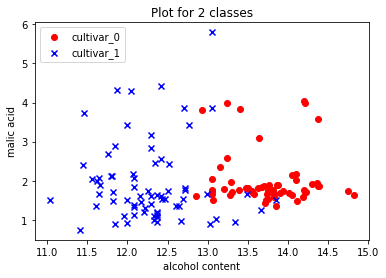

In [10]:
# change this parameter depending on how many classes you want to predict
classes = 2

if classes == 2:
    # keep only class_values == 0 or 1; and alcohol and malic acid features only (extend to more features to practice more!)
    X, y = df.iloc[:130, 1:3].values, df.iloc[:130, 0].values
    print('Length X:', len(X))
    print('Length y:', len(y))

elif classes == 3:
    # keep all class values; and alcohol and malic acid features only (extend to more features to practice more!)
    X, y = df.iloc[:, 1:3].values, df.iloc[:, 0].values
    print('Length X:', len(X))
    print('Length y:', len(y))


# plot X data for class 0
plt.scatter(X[:59, 0], X[:59, 1],
           color='red', marker='o', label='cultivar_0');

# plot X data for class 1
plt.scatter(X[59:130, 0], X[59:130, 1],
           color='blue', marker='x', label='cultivar_1');

if classes == 3:
    # plot X data for class 2
    plt.scatter(X[130:, 0], X[130:, 1],
               color='green', marker='d', label='cultivar_2');

plt.xlabel('alcohol content')
plt.ylabel('malic acid')
plt.legend(loc='upper left')
plt.title('Plot for ' + str(classes) + ' classes')

# plt.savefig('images/02_06.png', dpi=300)
plt.show();

##### Step 6.3.2 Split data into train and test sets

In [11]:
# note that I only crate training and test sets (so no validation set) because I do not plan to do hyperparameter tuning.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=1, stratify=y)

Question: what does stratify do here?

#### Step 6.3.3 Scale (standardize) features for optimal performance

In [12]:
sc = StandardScaler() #you can find this in the preprocessing model of scikit-learn
# estimate the sample mean and standard deviation for each feature in X_train
sc.fit(X_train)

# use the two parameters to standardize both X_train and X_test
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
print('X_train:')
print(X_train[:5])
print('X_train_standardized:')
print(X_train_std[:5])

X_train:
[[12.17  1.45]
 [11.66  1.88]
 [12.08  1.83]
 [11.03  1.51]
 [14.38  1.87]]
X_train_standardized:
[[-0.79830788 -0.68293079]
 [-1.37774905 -0.16981478]
 [-0.9005622  -0.22947943]
 [-2.09352933 -0.6113332 ]
 [ 1.71260388 -0.18174771]]


Note how we fit the StandardScaler() only on the training data, and use the mean and sd parameters to transform the test data!

---
### Step 7: Analysis - KNN as a classification algorithm
---

It's a very different algorithm compared to the ones we will see in this course.

It's also called a **lazy learner** because it doesn't learn any discriminative function from the training data, but memorizes the data instead.

Advantages:
- adapts easily to new data.

Disadvantages:
- we cannot discard training examples because no training is involved.
- storage space can become a challenge with large datasets.
- computationally complexity grows linearly with the size of the data.

Algorithm idea:
- Step 1: choose the number of k (neighbors) and a distance metric.
- Step 2: Find the k-nearest neighbors of the record we want to classify.
- Step 3: Assign the class label by majority vote.

Image source: Python Machine Learning 3rd Edition by [Sebastian Raschka] 



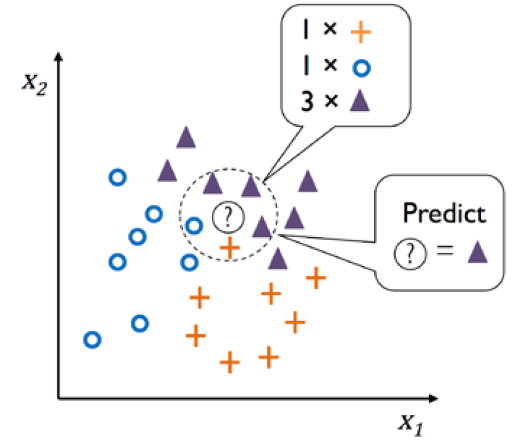

In [13]:
print('Image source: Python Machine Learning 3rd Edition by [Sebastian Raschka] \n')
Image(filename='./images/KNN.png', width=300) 

---
##### Step 7.1 Train

In [14]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

KNeighborsClassifier()

Experimenting with the value of K is important to avoid overfitting or underfitting.

Metric defines the distance metric to use. The default metric is minkowski. With p=2 is equivalent to the standard Euclidean metric, and with p=1 is equivalent to the Manhattan distance. 

Check here for other distance metrics available in scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

<span style="color:chocolate">Exercise</span>: create a validation set and perform hyperparameter tuning before you move to the Evaluation stage!

##### Step 7.2 Evaluation

Based on the chosen distance metric, the KNN algorithm finds the k examples in the training dataset that are closest to the point (in the test set) that we want to clasify.

In [15]:
y_pred = knn.predict(X_test_std)

print('Length y_pred: ', len(y_pred))
print('Predicted class labels for each test example:')
print(y_pred)
y_test

Length y_pred:  39
Predicted class labels for each test example:
[1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0
 1 0]


array([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0])

In [16]:
len(y_test)

39

##### Step 7.3 Performance evaluation metrics

In the previous live-session we evaluated the performance of the ML algorithms using the **prediction error** and **prediction accuracy**, which are useful metrics but not the only one we can use to check a model performance.

In [17]:
print('Misclassified examples: %d (out of 26)' % (y_test != y_pred).sum())
error = (y_test != y_pred).sum()/len(y_pred)
print('Prediction error: %.3f' % error)
print('Prediction accuracy: %.3f'% (1-error))

Misclassified examples: 3 (out of 26)
Prediction error: 0.077
Prediction accuracy: 0.923


Other performance metrics that we can use include **precision**, **recall**, and the **F1 score**. Before I show you how to implement them, let's take a look at the **confusion matrix**.

A confusion matrix is a square matrix that reports the count of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN).

Image source: Python Machine Learning 3rd Edition by [Sebastian Raschka] 



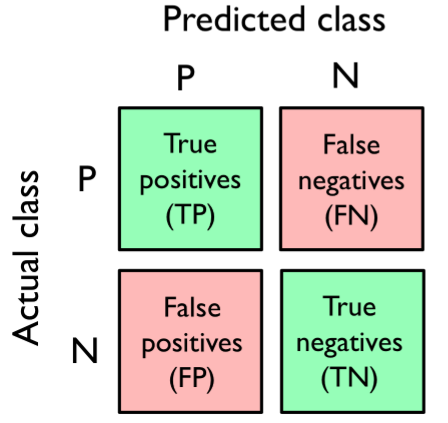

In [18]:
print('Image source: Python Machine Learning 3rd Edition by [Sebastian Raschka] \n')
Image(filename='./images/confusion_matrix.png', width=200) 

The **precision** and **recall** metrics are related to the TP and TN rates, as follows:

$precision = \frac{TP}{TP + FP}$, emphasizes correctness, but doesn't pay attention to FN.

$recall = \frac{TP}{TP+FN}$, minimizes the chance of not detecting a FN, but doesn't pay attention to FP.
    

The **F1 score** provides a balance between the precission and recall metrics:

$F1 = 2 \times \frac{precision * recall}{precision + recall}$

Let's go back to our wine data now to see the results of the confusion matrix.

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred) # confusion_matrix is available in sklearn.metrics
conf_matrix

array([[17,  1],
       [ 2, 19]])

Let's plot the conf_matrix in a format that makes it easier to read.

Question: How do you interpret the results?

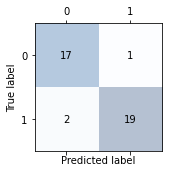

In [20]:
confusion_matrix_plot(conf_matrix)

Let's now look at the value of precision, recall, and F1 metrics. No need to write our own formulas, we can use the methods implemented in the scikit.metrics module.

Question: what does the average parameter do in the code below?

In [21]:
print('Precision score: %.3f' % precision_score(y_test, y_pred, average='macro'))
print('Recall score: %.3f' % recall_score(y_test, y_pred, average='macro'))
print('F1 score %.3f' % f1_score(y_test, y_pred, average='macro'))

Precision score: 0.922
Recall score: 0.925
F1 score 0.923


Question: which class it the most difficult for the K=5 model to recognize?

Answer: print a classification report. This will return the metrics for each class separately

In [22]:
print('\n Classification report for k=5:\n', classification_report(y_test, y_pred))


 Classification report for k=5:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92        18
           1       0.95      0.90      0.93        21

    accuracy                           0.92        39
   macro avg       0.92      0.92      0.92        39
weighted avg       0.92      0.92      0.92        39



##### Step 7.4 Visualize the decission bounderies

We want to visualize how well the KNN separates the 2 different wine cultivars (note that this time we plot the test data as well).

We can see that the KNN has done a pretty good job at separating the 2 classes.

<ipython-input-2-f2ec4d78feea>:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


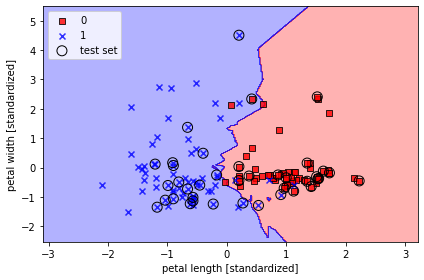

In [23]:
# combine training and test data
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# plot decission bounderies
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn,  plot_test=1, len_y=len(y), len_y_pred=len(y_pred))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_24.png', dpi=300)
plt.show()


KNN is very susceptible to the **course of dimensionality**. In a high-dimensional space, the feature space becomes very sparse with an increase in the number of features, so even the 'closest neighbors' may be too far away. 

Two techniques to avoid the course of dimensionality in KNN:
- feature selection.
- dimensionality reduction.

When classes overlap, classification accuracy decreases. Why?

---
TO DOs in the breakout rooms:

For this exercise you will create a new notebook and you will be working with the diabetes.csv dataset (week02).

Here are the tasks:

   - [a] Read in the data. <br>
   - [b] Preprocess the data (do not forget to split data into training and test. <br>
   - [c] Run KNN to predict diabetes status. Comment on classification accuracy. <br>
   - [c] Experiment with the distance metric. Comment on classification accuracy. <br>

Good luck!